# Machine Learning with PySpark

In [1]:
%matplotlib inline

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
plt.rcParams.update({'font.size': 15})

# Normal distribution from scipy
from scipy.stats import norm

# Pyspark modules
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark import sql, SparkContext, SparkConf
from pyspark.sql.functions import *
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
# Import custom class
%run '../src/helper/pyspark_transfxn.py'

In [3]:
# Instantiate the class
transfxn = TransformationPipeline(label_col = 'bad')

In [4]:
# Create spark session
spark = SparkSession.builder.appName("project").getOrCreate()

# Load data

In [5]:
df = spark.read.csv('../data/hmeq.csv', inferSchema = True, header = True)   # load data

df.createOrReplaceTempView("raw_table") # create table for sql query

df = df.toDF(*[c.lower() for c in df.columns]) # column names in lower case

# print data size and display sample
print("Data size:", (df.count(), len(df.columns)))
df.show()

Data size: (5960, 13)
+---+----+--------+--------+-------+------+----+-----+------+------------+----+----+------------+
|bad|loan| mortdue|   value| reason|   job| yoj|derog|delinq|       clage|ninq|clno|     debtinc|
+---+----+--------+--------+-------+------+----+-----+------+------------+----+----+------------+
|  1|1100| 25860.0| 39025.0|HomeImp| Other|10.5|    0|     0|94.366666667|   1|   9|        null|
|  1|1300| 70053.0| 68400.0|HomeImp| Other| 7.0|    0|     2|121.83333333|   0|  14|        null|
|  1|1500| 13500.0| 16700.0|HomeImp| Other| 4.0|    0|     0|149.46666667|   1|  10|        null|
|  1|1500|    null|    null|   null|  null|null| null|  null|        null|null|null|        null|
|  0|1700| 97800.0|112000.0|HomeImp|Office| 3.0|    0|     0|93.333333333|   0|  14|        null|
|  1|1700| 30548.0| 40320.0|HomeImp| Other| 9.0|    0|     0|101.46600191|   1|   8|37.113613558|
|  1|1800| 48649.0| 57037.0|HomeImp| Other| 5.0|    3|     2|        77.1|   1|  17|        null

In [6]:
df.printSchema()

root
 |-- bad: integer (nullable = true)
 |-- loan: integer (nullable = true)
 |-- mortdue: double (nullable = true)
 |-- value: double (nullable = true)
 |-- reason: string (nullable = true)
 |-- job: string (nullable = true)
 |-- yoj: double (nullable = true)
 |-- derog: integer (nullable = true)
 |-- delinq: integer (nullable = true)
 |-- clage: double (nullable = true)
 |-- ninq: integer (nullable = true)
 |-- clno: integer (nullable = true)
 |-- debtinc: double (nullable = true)



# Class distribution

In [7]:
query = """ 
select 
    bad, 
    count(*) as count,
    round(count(*)*100/(select count(*) from raw_table),2) as percentage
from raw_table
group by 1
order by 1
"""
spark.sql(query).show()

+---+-----+----------+
|bad|count|percentage|
+---+-----+----------+
|  0| 4771|     80.05|
|  1| 1189|     19.95|
+---+-----+----------+



# Missing values

In [8]:
df_missing = df.agg(*[count(c).alias(c) for c in df.columns])
df_missing.show()

+----+----+-------+-----+------+----+----+-----+------+-----+----+----+-------+
| bad|loan|mortdue|value|reason| job| yoj|derog|delinq|clage|ninq|clno|debtinc|
+----+----+-------+-----+------+----+----+-----+------+-----+----+----+-------+
|5960|5960|   5442| 5848|  5708|5681|5445| 5252|  5380| 5652|5450|5738|   4693|
+----+----+-------+-----+------+----+----+-----+------+-----+----+----+-------+



In [9]:
# Count missing values in each variable
df.agg(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()

+---+----+-------+-----+------+---+---+-----+------+-----+----+----+-------+
|bad|loan|mortdue|value|reason|job|yoj|derog|delinq|clage|ninq|clno|debtinc|
+---+----+-------+-----+------+---+---+-----+------+-----+----+----+-------+
|  0|   0|    518|  112|   252|279|515|  708|   580|  308| 510| 222|   1267|
+---+----+-------+-----+------+---+---+-----+------+-----+----+----+-------+



## Missing values in  categorical variables

In [10]:
df.groupBy('job')\
    .count()\
    .sort(desc("count"))\
    .show()

+-------+-----+
|    job|count|
+-------+-----+
|  Other| 2388|
|ProfExe| 1276|
| Office|  948|
|    Mgr|  767|
|   null|  279|
|   Self|  193|
|  Sales|  109|
+-------+-----+



In [11]:
df.groupBy('reason')\
    .count()\
    .sort(desc("count"))\
    .show()

+-------+-----+
| reason|count|
+-------+-----+
|DebtCon| 3928|
|HomeImp| 1780|
|   null|  252|
+-------+-----+



In [12]:
# Fill with the most frequent (mode)
df = transfxn.one_val_imputer(df, ['job'], impute_with = 'Other')
df = transfxn.one_val_imputer(df, ['reason'], impute_with = 'DebtCon')

# Convert numerical variables to numeric

In [13]:
dont_cols = ['bad', 'job', 'reason']
df = transfxn.df_to_numeric(df, dont_cols)

# Create a test set
We split the data into 50 $\%$ training set, 30 $\%$ validation set,  and 20 $\%$ test set


In [14]:
trainDF, validDF, testDF = df.randomSplit([.5, 0.3, .2], seed=42)

In [15]:
print('Training set size:', (trainDF.count(), len(trainDF.columns)))
print('Validation set size:', (validDF.count(), len(validDF.columns)))
print('Test set size:', (testDF.count(), len(testDF.columns)))

Training set size: (3023, 13)
Validation set size: (1794, 13)
Test set size: (1143, 13)


# Transformation pipelines

In [16]:
# Transform and scale data
assembler, trainDF_scaled, validDF_scaled, testDF_scaled = transfxn.preprocessing(trainDF,validDF, testDF)

In [17]:
cols = ['features', 'bad','loan', 'reason']
trainDF_scaled.select(cols).show(5)

+--------------------+---+------+-------+
|            features|bad|  loan| reason|
+--------------------+---+------+-------+
|(16,[3,6,7,8,9,12...|  0|2400.0|HomeImp|
|(16,[3,6,7,8,9,12...|  0|2900.0|HomeImp|
|(16,[3,6,7,8,9,12...|  0|3000.0|HomeImp|
|[0.0,0.0,0.0,0.0,...|  0|3200.0|HomeImp|
|(16,[2,6,7,8,9,12...|  0|3600.0|HomeImp|
+--------------------+---+------+-------+
only showing top 5 rows



# A. Logistic Regression

In [27]:
# Train a logistic regression model.
lr = LogisticRegression(labelCol = "bad", featuresCol = "features", maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# Fit the training set 
lr_model = lr.fit(trainDF_scaled)

# Make predictions on the validation set
lr_val_pred = lr_model.transform(validDF_scaled)

# Select example rows to display
cols = ["features", "bad", "rawPrediction", "prediction"]
lr_val_pred.select(cols).show(5)

+--------------------+---+--------------------+----------+
|            features|bad|       rawPrediction|prediction|
+--------------------+---+--------------------+----------+
|(16,[3,6,7,8,9,12...|  0|[0.69895630102189...|       0.0|
|(16,[0,4,6,7,8,9,...|  0|[0.69895630102189...|       0.0|
|(16,[5,6,7,8,9,12...|  0|[0.69895630102189...|       0.0|
|(16,[2,6,7,8,9,12...|  0|[0.69895630102189...|       0.0|
|[0.0,0.0,0.0,0.0,...|  0|[0.69895630102189...|       0.0|
+--------------------+---+--------------------+----------+
only showing top 5 rows



## A-1: Performance metrics on the validation set

In [28]:
transfxn.print_eval_metrics(lr_val_pred, model_nm = 'Logistic Regression')

Performance metrics for Logistic Regression
------------------------------------------------------------
AUROC: 0.500000
AUPRC: 0.201226
Predicted classes: [0.]
Confusion matrix:
 [[1433    0]
 [ 361    0]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      1433
           1       0.00      0.00      0.00       361

    accuracy                           0.80      1794
   macro avg       0.40      0.50      0.44      1794
weighted avg       0.64      0.80      0.71      1794

------------------------------------------------------------


## A-2. Hyperparameter tuning
We now optimize the AUROC of Logistic regression using grid search and 5-fold cross-validation

In [29]:
paramGrid = ParamGridBuilder()\
            .addGrid(lr.regParam, [.01, .1, 1, 10])\
            .addGrid(lr.elasticNetParam, [0, .5, 1])\
            .build()

evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', 
                                         labelCol= 'bad', metricName="areaUnderROC"
                                         )
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator,
 numFolds=5, seed=42)

In [30]:
# Fit the training set
cv_lr = cv.fit(trainDF_scaled)
list(zip(cv_lr.getEstimatorParamMaps(), cv_lr.avgMetrics))

[({Param(parent='LogisticRegression_7c3c68f0b689', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
   Param(parent='LogisticRegression_7c3c68f0b689', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0},
  0.7810006105255931),
 ({Param(parent='LogisticRegression_7c3c68f0b689', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
   Param(parent='LogisticRegression_7c3c68f0b689', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5},
  0.7776332910914643),
 ({Param(parent='LogisticRegression_7c3c68f0b689', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
   Param(parent='LogisticRegression_7c3c68f0b689', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 pen

In [31]:
# Make predictions on the validation set
lr_cv_pred = cv_lr.transform(validDF_scaled)
transfxn.print_eval_metrics(lr_cv_pred, model_nm = 'Logistic Regression')

Performance metrics for Logistic Regression
------------------------------------------------------------
AUROC: 0.796962
AUPRC: 0.590704
Predicted classes: [0. 1.]
Confusion matrix:
 [[1391   42]
 [ 252  109]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.97      0.90      1433
           1       0.72      0.30      0.43       361

    accuracy                           0.84      1794
   macro avg       0.78      0.64      0.67      1794
weighted avg       0.82      0.84      0.81      1794

------------------------------------------------------------


## A-2: Performance metrics on the test set

In [32]:
# Make predictions on the test set
lr_test_pred = cv_lr.transform(testDF_scaled)
transfxn.print_eval_metrics(lr_test_pred, model_nm = 'Logistic Regression')

Performance metrics for Logistic Regression
------------------------------------------------------------
AUROC: 0.814081
AUPRC: 0.597725
Predicted classes: [0. 1.]
Confusion matrix:
 [[892  22]
 [161  68]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       914
           1       0.76      0.30      0.43       229

    accuracy                           0.84      1143
   macro avg       0.80      0.64      0.67      1143
weighted avg       0.83      0.84      0.81      1143

------------------------------------------------------------


# B. Random Forest Classifier

In [33]:
# Train a random forest classifier.
rf = RandomForestClassifier(labelCol = "bad", featuresCol = "features",  numTrees = 1000,  maxDepth = 5
)

# Fit the training set 
rf_model = rf.fit(trainDF_scaled)

# Make predictions on the validation set
rf_val_pred = rf_model.transform(validDF_scaled)

# Select example rows to display
cols = ["features", "bad", "rawPrediction", "prediction", 'probability']
rf_val_pred.select(cols).show(5)

+--------------------+---+--------------------+----------+--------------------+
|            features|bad|       rawPrediction|prediction|         probability|
+--------------------+---+--------------------+----------+--------------------+
|(16,[3,6,7,8,9,12...|  0|[639.037236101985...|       0.0|[0.63903723610198...|
|(16,[0,4,6,7,8,9,...|  0|[638.667609713591...|       0.0|[0.63866760971359...|
|(16,[5,6,7,8,9,12...|  0|[582.368754951657...|       0.0|[0.58236875495165...|
|(16,[2,6,7,8,9,12...|  0|[720.292787538712...|       0.0|[0.72029278753871...|
|[0.0,0.0,0.0,0.0,...|  0|[498.275949415147...|       1.0|[0.49827594941514...|
+--------------------+---+--------------------+----------+--------------------+
only showing top 5 rows



## B-1: Performance metrics on the validation set

In [34]:
transfxn.print_eval_metrics(rf_val_pred, model_nm = 'Random Forest Classifier')

Performance metrics for Random Forest Classifier
------------------------------------------------------------
AUROC: 0.909130
AUPRC: 0.778492
Predicted classes: [0. 1.]
Confusion matrix:
 [[1424    9]
 [ 255  106]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.92      1433
           1       0.92      0.29      0.45       361

    accuracy                           0.85      1794
   macro avg       0.88      0.64      0.68      1794
weighted avg       0.86      0.85      0.82      1794

------------------------------------------------------------


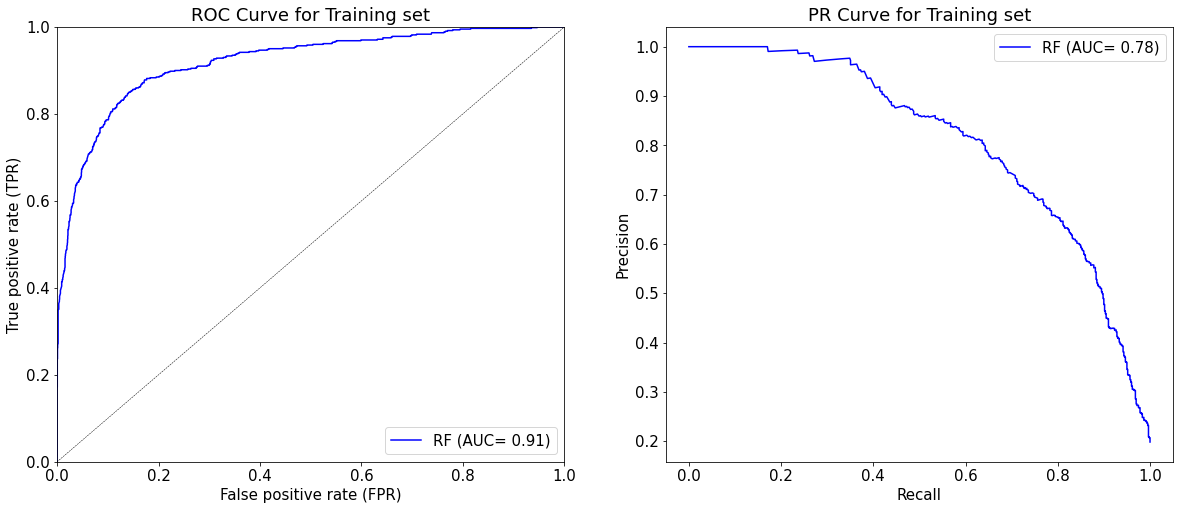

In [25]:
plt.figure(figsize = (20,8))

transfxn.plot_roc_pr_curves(rf_model, rf_val_pred, title = 'Training set', label= 'RF (AUC= %0.2f)')

## B-2. Feature Importances

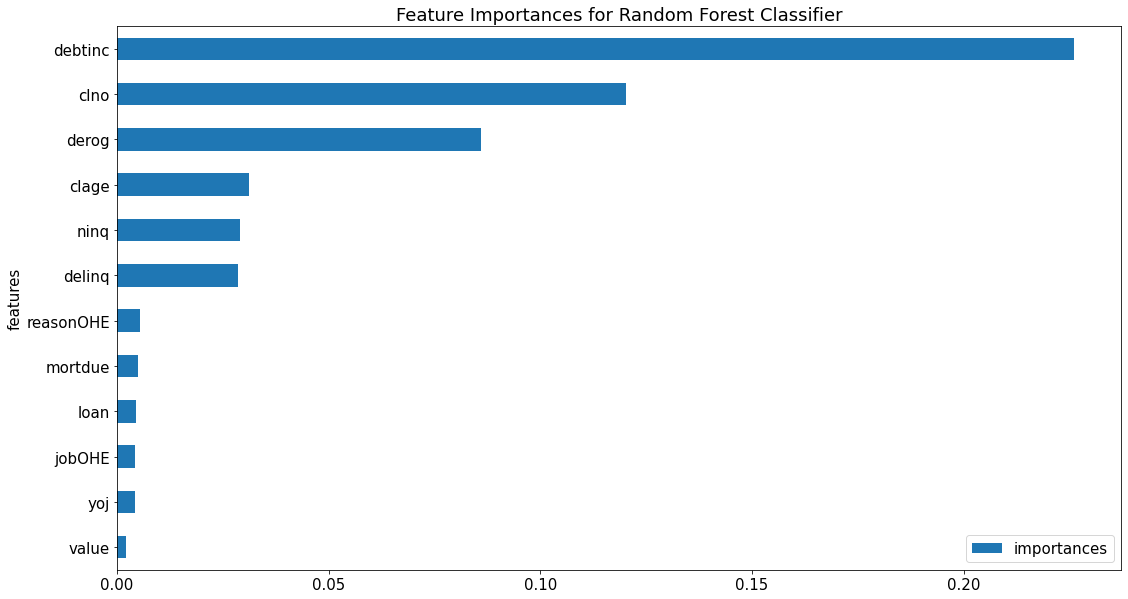

In [35]:
# Feature importances
feature_imp = pd.DataFrame(
      list(zip(assembler.getInputCols(), rf_model.featureImportances)), 
      columns=["features", "importances"]
      )
# Plot bar chart
feature_imp.sort_values('importances', ascending = True, inplace = True)
feature_imp.set_index('features', inplace = True)
feature_imp.plot(kind='barh', figsize = (18,10))
plt.title('Feature Importances for Random Forest Classifier')
plt.show()

## B-3. Hyperparameter tuning
We now optimize the AUROC of Random forest regressor using grid search and 5-fold cross-validation

In [36]:
paramGrid = ParamGridBuilder()\
            .addGrid(rf.maxDepth, [4,6,10])\
            .addGrid(rf.maxBins, [20,60])\
            .build()

evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', 
                                         labelCol= 'bad', metricName="areaUnderROC"
                                         )
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator,
 numFolds=5, seed=42)

In [37]:
# Fit the training set
cv_model = cv.fit(trainDF_scaled)
list(zip(cv_model.getEstimatorParamMaps(), cv_model.avgMetrics))

[({Param(parent='RandomForestClassifier_bc5caf7e380b', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4,
   Param(parent='RandomForestClassifier_bc5caf7e380b', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 20},
  0.8759086396301523),
 ({Param(parent='RandomForestClassifier_bc5caf7e380b', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4,
   Param(parent='RandomForestClassifier_bc5caf7e380b', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 60},
  0.8830963628269869),
 ({Param(parent='RandomForestClassifier_bc5caf7e380b', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf no

In [38]:
# Make predictions on the validation set
rf_cv_pred = cv_model.transform(validDF_scaled)
transfxn.print_eval_metrics(rf_cv_pred, model_nm = 'Random Forest Classifier')

Performance metrics for Random Forest Classifier
------------------------------------------------------------
AUROC: 0.946622
AUPRC: 0.846699
Predicted classes: [0. 1.]
Confusion matrix:
 [[1403   30]
 [ 149  212]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      1433
           1       0.88      0.59      0.70       361

    accuracy                           0.90      1794
   macro avg       0.89      0.78      0.82      1794
weighted avg       0.90      0.90      0.89      1794

------------------------------------------------------------


## B-4. Performance metrics on the test set

In [39]:
rf_test_pred = cv_model.transform(testDF_scaled)
transfxn.print_eval_metrics(rf_test_pred, model_nm = 'Random Forest Classifier')

Performance metrics for Random Forest Classifier
------------------------------------------------------------
AUROC: 0.965333
AUPRC: 0.906880
Predicted classes: [0. 1.]
Confusion matrix:
 [[902  12]
 [ 91 138]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95       914
           1       0.92      0.60      0.73       229

    accuracy                           0.91      1143
   macro avg       0.91      0.79      0.84      1143
weighted avg       0.91      0.91      0.90      1143

------------------------------------------------------------


# C. Gradient-Boosted Tree Classifier

In [40]:
# Train a Gradient-boosted tree classifier model
gbt = GBTClassifier(labelCol = "bad", featuresCol = "features", maxDepth = 5, maxIter= 100)

# Fit the training set 
gbt_model = gbt.fit(trainDF_scaled)

# Make predictions on the validation set
gbt_val_pred = gbt_model.transform(validDF_scaled)

# Select example rows to display
cols = ["features", "bad", "rawPrediction", "prediction", 'probability']
gbt_val_pred.select(cols).show(5)

+--------------------+---+--------------------+----------+--------------------+
|            features|bad|       rawPrediction|prediction|         probability|
+--------------------+---+--------------------+----------+--------------------+
|(16,[3,6,7,8,9,12...|  0|[0.32614257034010...|       0.0|[0.65752522898582...|
|(16,[0,4,6,7,8,9,...|  0|[-0.6741863377654...|       1.0|[0.20613654678055...|
|(16,[5,6,7,8,9,12...|  0|[0.12998036937843...|       0.0|[0.56462664049534...|
|(16,[2,6,7,8,9,12...|  0|[1.17063743465462...|       0.0|[0.91223820443265...|
|[0.0,0.0,0.0,0.0,...|  0|[-0.3266737752750...|       1.0|[0.34223557144940...|
+--------------------+---+--------------------+----------+--------------------+
only showing top 5 rows



## C-1. Performance metrics on the validation set

In [41]:
transfxn.print_eval_metrics(gbt_val_pred, model_nm = 'GBT Classifier')

Performance metrics for GBT Classifier
------------------------------------------------------------
AUROC: 0.942789
AUPRC: 0.838521
Predicted classes: [0. 1.]
Confusion matrix:
 [[1371   62]
 [ 118  243]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      1433
           1       0.80      0.67      0.73       361

    accuracy                           0.90      1794
   macro avg       0.86      0.81      0.83      1794
weighted avg       0.90      0.90      0.90      1794

------------------------------------------------------------


## C-2. Feature Importances

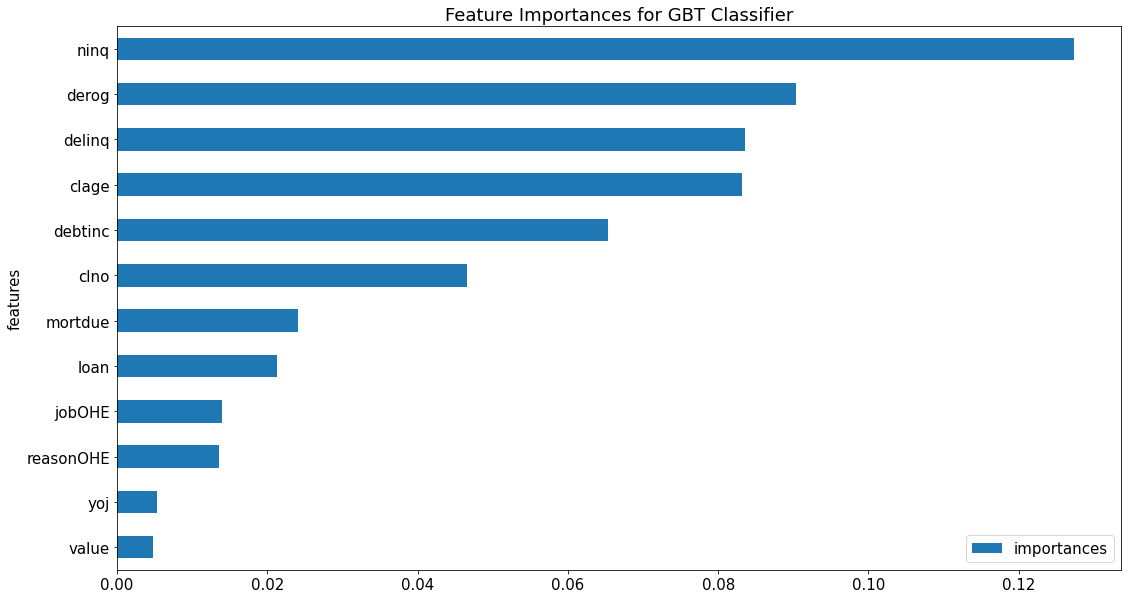

In [42]:
# Feature importances
feature_imp = pd.DataFrame(
      list(zip(assembler.getInputCols(), gbt_model.featureImportances)), 
      columns=["features", "importances"]
      )

# Plot bar chart
feature_imp.sort_values('importances', ascending = True, inplace = True)
feature_imp.set_index('features', inplace = True)
feature_imp.plot(kind='barh', figsize = (18,10))
plt.title('Feature Importances for GBT Classifier')
plt.show()

## C-3. Performance metrics on the test set

In [43]:
# Make predictions on the validation set
gbt_test_pred = gbt_model.transform(testDF_scaled)
transfxn.print_eval_metrics(gbt_test_pred, model_nm = 'GBT Classifier')

Performance metrics for GBT Classifier
------------------------------------------------------------
AUROC: 0.953523
AUPRC: 0.890016
Predicted classes: [0. 1.]
Confusion matrix:
 [[891  23]
 [ 73 156]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95       914
           1       0.87      0.68      0.76       229

    accuracy                           0.92      1143
   macro avg       0.90      0.83      0.86      1143
weighted avg       0.91      0.92      0.91      1143

------------------------------------------------------------
